In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/gl*obal/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

In [3]:
era5d2_seasmean = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_168_2d.2001-2018.nc").groupby('time.month').mean()
era5psfc_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.128_134_sp.2001-2018.nc")
era5q2_seasmean = era5d2_seasmean**0*np.array(mpcalc.specific_humidity_from_dewpoint(np.array(era5d2_seasmean)*units.K,np.array(era5psfc_seasmean)*units.Pa))

In [12]:
#Ghats      = MountainRange("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,7 ,0.)#[66,81,8,23]   
#Myanmar    = MountainRange("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,7 ,0.)#[85,102,9,24]  
#Vietnam    = MountainRange("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,10,0.)#[102,115,8,23] 
#Malaysia   = MountainRange("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,11,0.)#[97,112,-1,11] 
#Philippines= MountainRange("philippines",[117,135,5,22] ,"Philippines"             ,225,12,0.)#[118,135,7,19] 
#Newbritain = MountainRange("newbritain" ,[145,163,-17,0],"New Britain"             ,320,7 ,0.)#[146,159,-12,0]

Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])
Cascades   = MountainRangeCustom("cascades"   ,[222,240,43,60],"British Columbia cascades",45 ,[1,11,12],[235,47,227,54,3])


MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain,Cascades)

for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Q_SFC',era5q2_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_uperp()
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain
cascades


In [14]:
#Ghats      .box_tilted = [ 75  ,   9  ,  71.5, 20   ,2  ]
#Myanmar    .box_tilted = [ 98  ,  11  ,  90  , 21   ,4  ]
#Vietnam    .box_tilted = [108  ,  18  , 111  , 13   ,2  ]
#Malaysia   .box_tilted = [102.5,   8  , 105.5,  3   ,2  ]
#Philippines.box_tilted = [123.5,  17  , 127  ,  9   ,2  ]
#Newbritain .box_tilted = [154  , - 6  , 150  , -8   ,2  ]

Vietnam    .box_upstream = [112, 115, 17, 20]
Ghats      .box_upstream = [68, 69, 10, 15]  
Myanmar    .box_upstream = [86,89,12,15]     
Newbritain .box_upstream = [153,155,-11,-9] 
Philippines.box_upstream = [129,130,13,20]    
Malaysia   .box_upstream = [105,107,7,9]    
Cascades   .box_upstream = [225,228,47,50]    


# Pr maps

In [8]:
def sel_months(ds,months):
    return ds.sel(month = np.in1d( ds['month'], months))

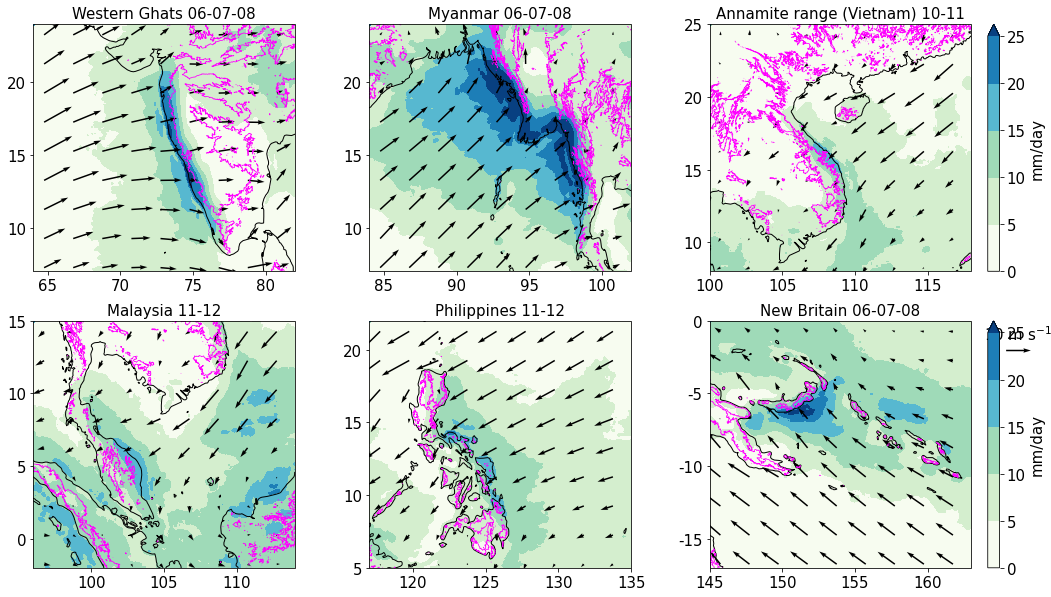

In [30]:
fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.2],height_ratios=[1,1],figure=fig)
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    ax.set_anchor('W')
    ax.coastlines()
    
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    if i%3 !=2:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    else:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,cbar_kwargs={'label':'mm/day'})
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
     
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+MR._monthstr,fontsize=15)

# Quiver key (reference wind arrow)
qk = ax.quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


# Linear theory in 2D

In [6]:
from orographicConvectionTheory.orographicConvectionTheory import k_vector,compute_Lq,lapse_rates

In [7]:
def m_exponent_2D(sigma,N,ksq):
    den = sigma**2
    EPS=1e-15
    den[den < EPS] = EPS
    return (den>=N**2)*1j*np.sqrt(ksq*(1-N**2/den)+0.j) + (den<N**2)*np.sign(sigma)*np.sqrt(ksq*(N**2/den-1)+0.j)

def linear_precip_theory_2D(xx,yy,hxy,U,V,tauT=3,tauq=11,P0=4.,switch=1,pad_factor=0.2):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lc=2.5e6
    dx = xx[1]-xx[0]
    dy = yy[1]-yy[0]
    tauT*=3600
    tauq*=3600
    
    # Pad boundaries
    calc_pad = int(pad_factor*np.max(hxy.shape))
    pad=calc_pad#pad = min([calc_pad, 200])
    pad_topo = int(100e3/dx)
    hxy_pad_topo = np.pad(hxy, pad_topo, 'linear_ramp',end_values = [0,0])
    hxy_pad = np.pad(hxy_pad_topo,pad-pad_topo,'constant')
    xx_pad = np.pad(xx, pad, 'linear_ramp',end_values = [xx[0]-pad*dx,xx[-1]+pad*dx])
    yy_pad = np.pad(yy, pad, 'linear_ramp',end_values = [yy[0]-pad*dy,yy[-1]+pad*dy])
    
    z=np.arange(0,10000,100)
    kx=k_vector(len(xx_pad),dx)
    ky=k_vector(len(yy_pad),dy)
    sigma = U*kx[:,None]+V*ky[None,:]
    ksq = kx[:,None]**2+ky[None,:]**2
    
    LqovU=compute_Lq(5,1,tauq)
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lc * 86400
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    
    
    m1 = m_exponent_2D(sigma,N,ksq)
    mm = np.copy(m1)
    mm[mm==0]=1e-8
    Pprimehat = (1j*sigma/(1j*sigma + switch*1/LqovU)) * chi * np.fft.fft2(hxy_pad) * ((m1!=0)*(np.exp( 1j* mm * ztop )-np.exp( 1j* mm * zbot ))/(1j*mm*(ztop-zbot)) + (m1==0)*1) #np.exp( 1j* m_exponent_2D(sigma,N,ksq)[:,:,None] *  z_slice[None,None,:] ).mean(axis=-1) 

    P = P0 + np.real(np.fft.ifft2(Pprimehat))
    P = np.maximum(0.,P)[pad:-pad, pad:-pad]
    return xr.DataArray(P,coords={'x':xx,'y':yy},dims=['x','y'])
    #P = np.maximum(0.,P)
    #return xr.DataArray(P,coords={'x':xx_pad,'y':yy_pad},dims=['x','y'])


CPU times: user 257 ms, sys: 54.8 ms, total: 312 ms
Wall time: 312 ms


(-1000000.0, 1000000.0)

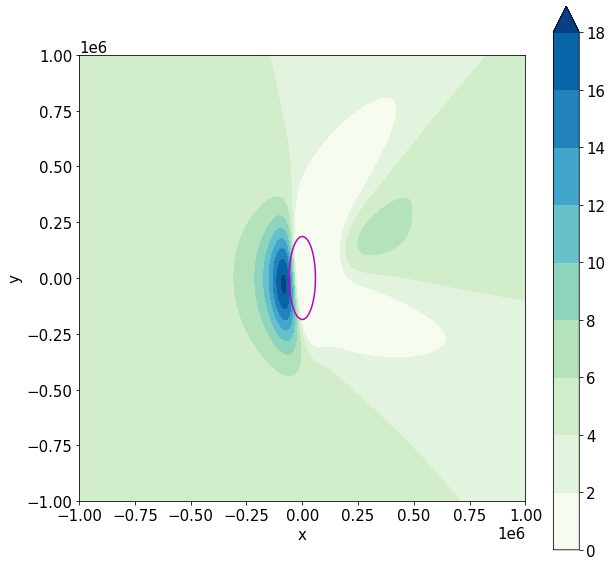

In [11]:
def topographic_profile_2D(a=100e3,A=1000):
    xx=np.arange(-3000e3,3000e3,10e3)
    yy=np.arange(-2000e3,2000e3,10e3)
    hxy = A*np.exp(-(xx[:,None]**2+yy[None,:]**2/10)/2/(a/2)**2)
    return xx,yy,hxy
xx,yy,hxy = topographic_profile_2D(); hxy_xr = xr.DataArray(hxy,coords={'x':xx,'y':yy},dims=['x','y'])
%time P = linear_precip_theory_2D(xx,yy,hxy,10,4,tauT=7.5,tauq=27.5)
P.plot.contourf(figsize=(10,10),x='x',levels=np.arange(0.,20.,2.),cmap=plt.cm.GnBu)
hxy_xr.plot.contour(x='x',levels=[500],colors=['m'])
plt.gca().set_aspect('equal')
plt.xlim(-1000e3,1000e3)
plt.ylim(-1000e3,1000e3)

# Smith theory in 2D

In [8]:
from orographicConvectionTheory.orographicConvectionTheory import hw_cw

In [9]:
def smith_theory_2D(xx,yy,hxy,U,V,gamma,gamma_m,ts=300.,ps=100000.,tau=2000, P0=4.,pad_factor=0.2):
    dx = xx[1]-xx[0]
    dy = yy[1]-yy[0]
    Hw,Cw = hw_cw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f s^-1"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f s^-1"%N)

    tau_c=tau
    tau_f=tau
    
    # Pad boundaries
    calc_pad = int(pad_factor*np.max(hxy.shape))
    pad=calc_pad#pad = min([calc_pad, 200])
    pad_topo = int(100e3/dx)
    hxy_pad_topo = np.pad(hxy, pad_topo, 'linear_ramp',end_values = [0,0])
    hxy_pad = np.pad(hxy_pad_topo,pad-pad_topo,'constant')
    xx_pad = np.pad(xx, pad, 'linear_ramp',end_values = [xx[0]-pad*dx,xx[-1]+pad*dx])
    yy_pad = np.pad(yy, pad, 'linear_ramp',end_values = [yy[0]-pad*dy,yy[-1]+pad*dy])
    
    z=np.arange(0,10000,100)
    kx=k_vector(len(xx_pad),dx)
    ky=k_vector(len(yy_pad),dy)
    sigma = U*kx[:,None]+V*ky[None,:]
    ksq = kx[:,None]**2+ky[None,:]**2
    
    m1 = m_exponent_2D(sigma,N,ksq)
    mm = np.copy(m1)
    mm[mm==0]=1e-8
    Pprimehat= 86400*Cw*np.fft.fft2(hxy_pad)*1j*sigma/(1-1j*Hw*mm)/(1+1j*sigma*tau_c)/(1+1j*sigma*tau_f)/2.5


    P = P0 + np.real(np.fft.ifft2(Pprimehat))
    P = np.maximum(0.,P)[pad:-pad, pad:-pad]
    return xr.DataArray(P,coords={'x':xx,'y':yy},dims=['x','y'])
    

using dry stability, N=0.011 s^-1
CPU times: user 215 ms, sys: 20.8 ms, total: 235 ms
Wall time: 234 ms


(-1000000.0, 1000000.0)

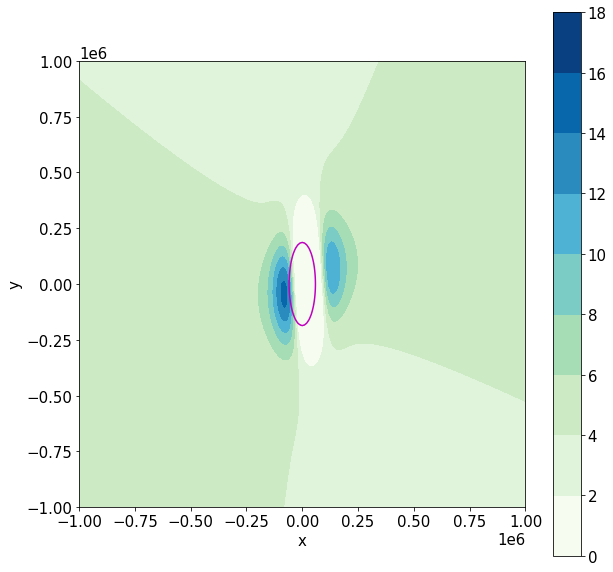

In [44]:
def topographic_profile_2D(a=100e3,A=1000):
    xx=np.arange(-3000e3,3000e3,10e3)
    yy=np.arange(-2000e3,2000e3,10e3)
    hxy = A*np.exp(-(xx[:,None]**2+yy[None,:]**2/10)/2/(a/2)**2)
    return xx,yy,hxy
xx,yy,hxy = topographic_profile_2D(); hxy_xr = xr.DataArray(hxy,coords={'x':xx,'y':yy},dims=['x','y'])
%time P = smith_theory_2D(xx,yy,hxy,5,2,6e-3,4.32e-3)
P.plot.contourf(figsize=(10,10),x='x',levels=np.arange(0.,20.,2.),cmap=plt.cm.GnBu)
hxy_xr.plot.contour(x='x',levels=[500],colors=['m'])
plt.gca().set_aspect('equal')
plt.xlim(-1000e3,1000e3)
plt.ylim(-1000e3,1000e3)

# Applying the linear theory to real data cases

In [10]:
def p_lineartheory_region(MR,U,V,topo='ETOPO',P0=4,tauT=7.5,tauq=27.5,pad='small'):
    if topo=='ETOPO':
        z = MR.vars['Z_HR']
    elif topo=='ETOPOCOARSE':
        z = MR.vars['Z_HR'].coarsen(latitude=4,longitude=4,boundary='trim').mean()
    elif topo=='ERA5':
        z = MR.vars['Z']
    else:
        raise ValueError('topo')
    hxy = np.array(z).T[:,::-1]
    lon = z.longitude
    lat = z.latitude[::-1]
    
    xx = np.array(lon)*100e3
    yy = np.array(lat)*100e3
    
    if pad=='small':
        pf=0.2
    elif pad=='big':
        pf=2
    P = linear_precip_theory_2D(xx,yy,hxy,U,V,tauT=tauT,tauq=tauq,P0=P0,pad_factor=pf)
    return P.assign_coords({'longitude':P.x/100e3,'latitude':P.y/100e3}).swap_dims({'x':'longitude','y':'latitude'})[:,::-1].transpose()

def p_smiththeory_region(MR,U,V,topo='ETOPO',P0=4,gamma=6e-3,gamma_m=4.32e-3,pad='small'):
    if topo=='ETOPO':
        z = MR.vars['Z_HR']
    elif topo=='ETOPOCOARSE':
        z = MR.vars['Z_HR'].coarsen(latitude=4,longitude=4,boundary='trim').mean()
    elif topo=='ERA5':
        z = MR.vars['Z']
    else:
        raise ValueError('topo')
    hxy = np.array(z).T[:,::-1]
    lon = z.longitude
    lat = z.latitude[::-1]
    
    xx = np.array(lon)*100e3
    yy = np.array(lat)*100e3
    
    if pad=='small':
        pf=0.2
    elif pad=='big':
        pf=2
    
    P = smith_theory_2D(xx,yy,hxy,U,V,gamma,gamma_m,P0=P0,pad_factor=pf)
    return P.assign_coords({'longitude':P.x/100e3,'latitude':P.y/100e3}).swap_dims({'x':'longitude','y':'latitude'})[:,::-1].transpose()


using dry stability, N=0.011 s^-1


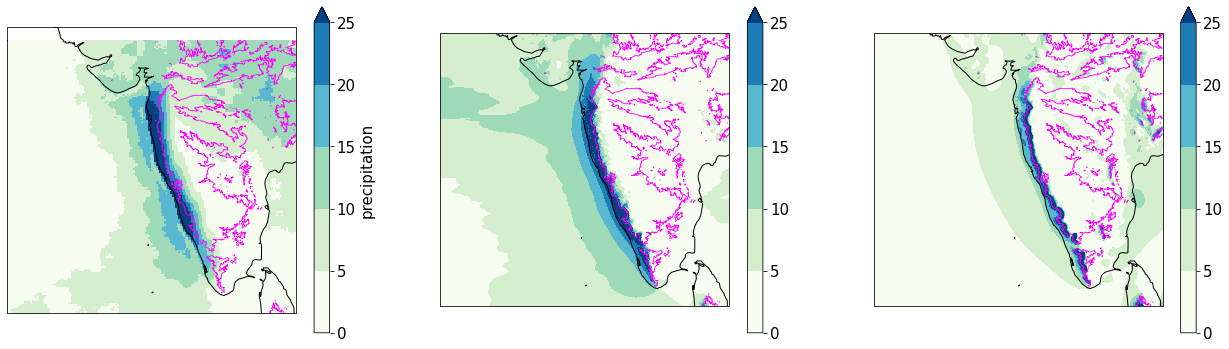

In [54]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,6),subplot_kw={"projection":ccrs.PlateCarree()})
Ghats.vars['GPM_PR'].plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu)
p_lineartheory_region(Ghats,10,1).plot.contourf(ax=ax2,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu)
p_smiththeory_region(Ghats,10,1).plot.contourf(ax=ax3,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu)

for ax in ax1,ax2,ax3:
    ax.coastlines()
    Ghats.vars['Z_HR'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['magenta'])
     

In [55]:
for MR in MRs:
    print(MR.name)
    u = spatial_mean(MR.vars['VAR_100U'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    v = spatial_mean(MR.vars['VAR_100V'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    pr = spatial_mean(MR.vars['GPM_PR'],box=MR.box_upstream,mask = None)
    print("U=%i,V=%i,Pr=%.1f"%(u,v,pr))

ghats
U=9,V=0,Pr=2.2
myanmar
U=6,V=6,Pr=9.6
vietnam
U=-3,V=-3,Pr=6.1
malaysia
U=-3,V=-2,Pr=5.9
philippines
U=-6,V=-4,Pr=5.3
newbritain
U=-5,V=6,Pr=7.9


In [15]:
for MR in (Cascades,):
    print(MR.name)
    u = spatial_mean(MR.vars['VAR_100U'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    v = spatial_mean(MR.vars['VAR_100V'],box=None,mask = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True))
    pr = spatial_mean(MR.vars['GPM_PR'],box=MR.box_upstream,mask = None)
    print("U=%i,V=%i,Pr=%.1f"%(u,v,pr))

cascades
U=2,V=3,Pr=6.8


In [16]:
Ghats      .U0 = 10; Ghats      .V0 =  1; Ghats      .P0 = 2
Myanmar    .U0 =  9; Myanmar    .V0 =  9; Myanmar    .P0 = 7
Vietnam    .U0 = -7; Vietnam    .V0 = -5; Vietnam    .P0 = 4
Malaysia   .U0 = -7; Malaysia   .V0 = -5; Malaysia   .P0 = 8
Philippines.U0 = -9; Philippines.V0 = -3; Philippines.P0 = 5
Newbritain .U0 = -9; Newbritain .V0 =  7; Newbritain .P0 = 6


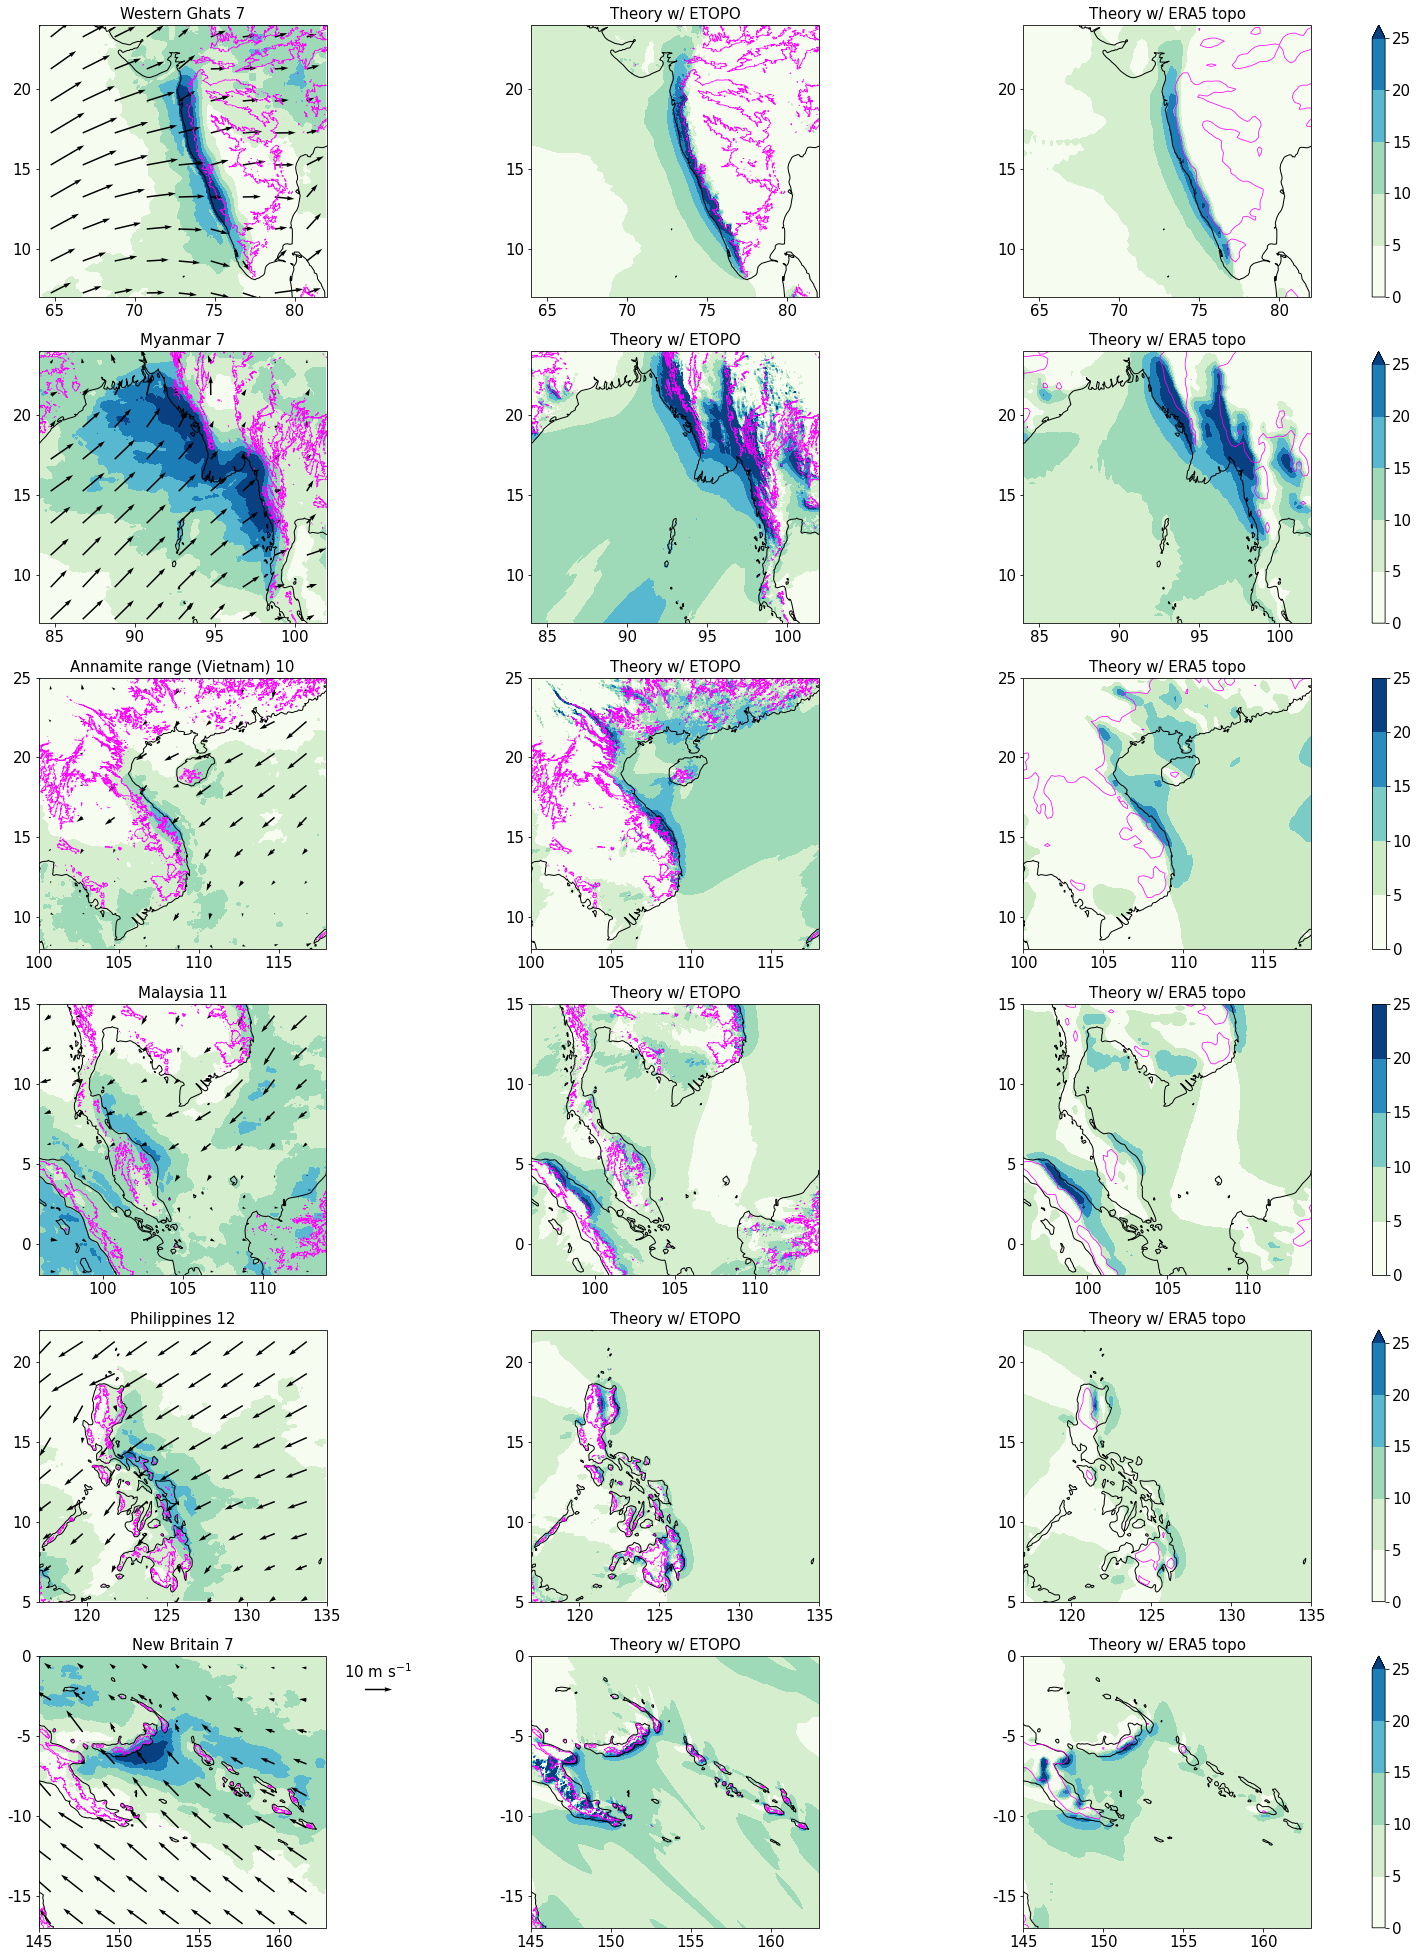

In [22]:

fig,axss = plt.subplots(6,3,figsize=(25,35),subplot_kw={'projection': ccrs.PlateCarree()})
for i,MR in enumerate(MRs):
    axs = axss[i]
    
    ax=axs[0]
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
     
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    ax=axs[1]
    p_lineartheory_region(MR,MR.U0,MR.V0,P0=MR.P0).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())

    ax=axs[2]
    p_lineartheory_region(MR,MR.U0,MR.V0,P0=MR.P0,topo='ERA5').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu)
    MR.vars['Z'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
    
    
    for ax in axs:
        ax.set_anchor('W')
        ax.coastlines()
        dl=5
        lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
        ax.set_xticks(lons)
        ax.set_xticklabels(lons)
        lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
        ax.set_yticks(lats)
        ax.set_yticklabels(lats)
        ax.set_xlabel("")
        ax.set_ylabel("")
    axs[0].set_title(MR.Lname +' '+str(MR.pr_month),fontsize=15)
    axs[1].set_title('Theory w/ ETOPO',fontsize=15)
    axs[2].set_title('Theory w/ ERA5 topo',fontsize=15)

# Quiver key (reference wind arrow)
qk = ax.quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1


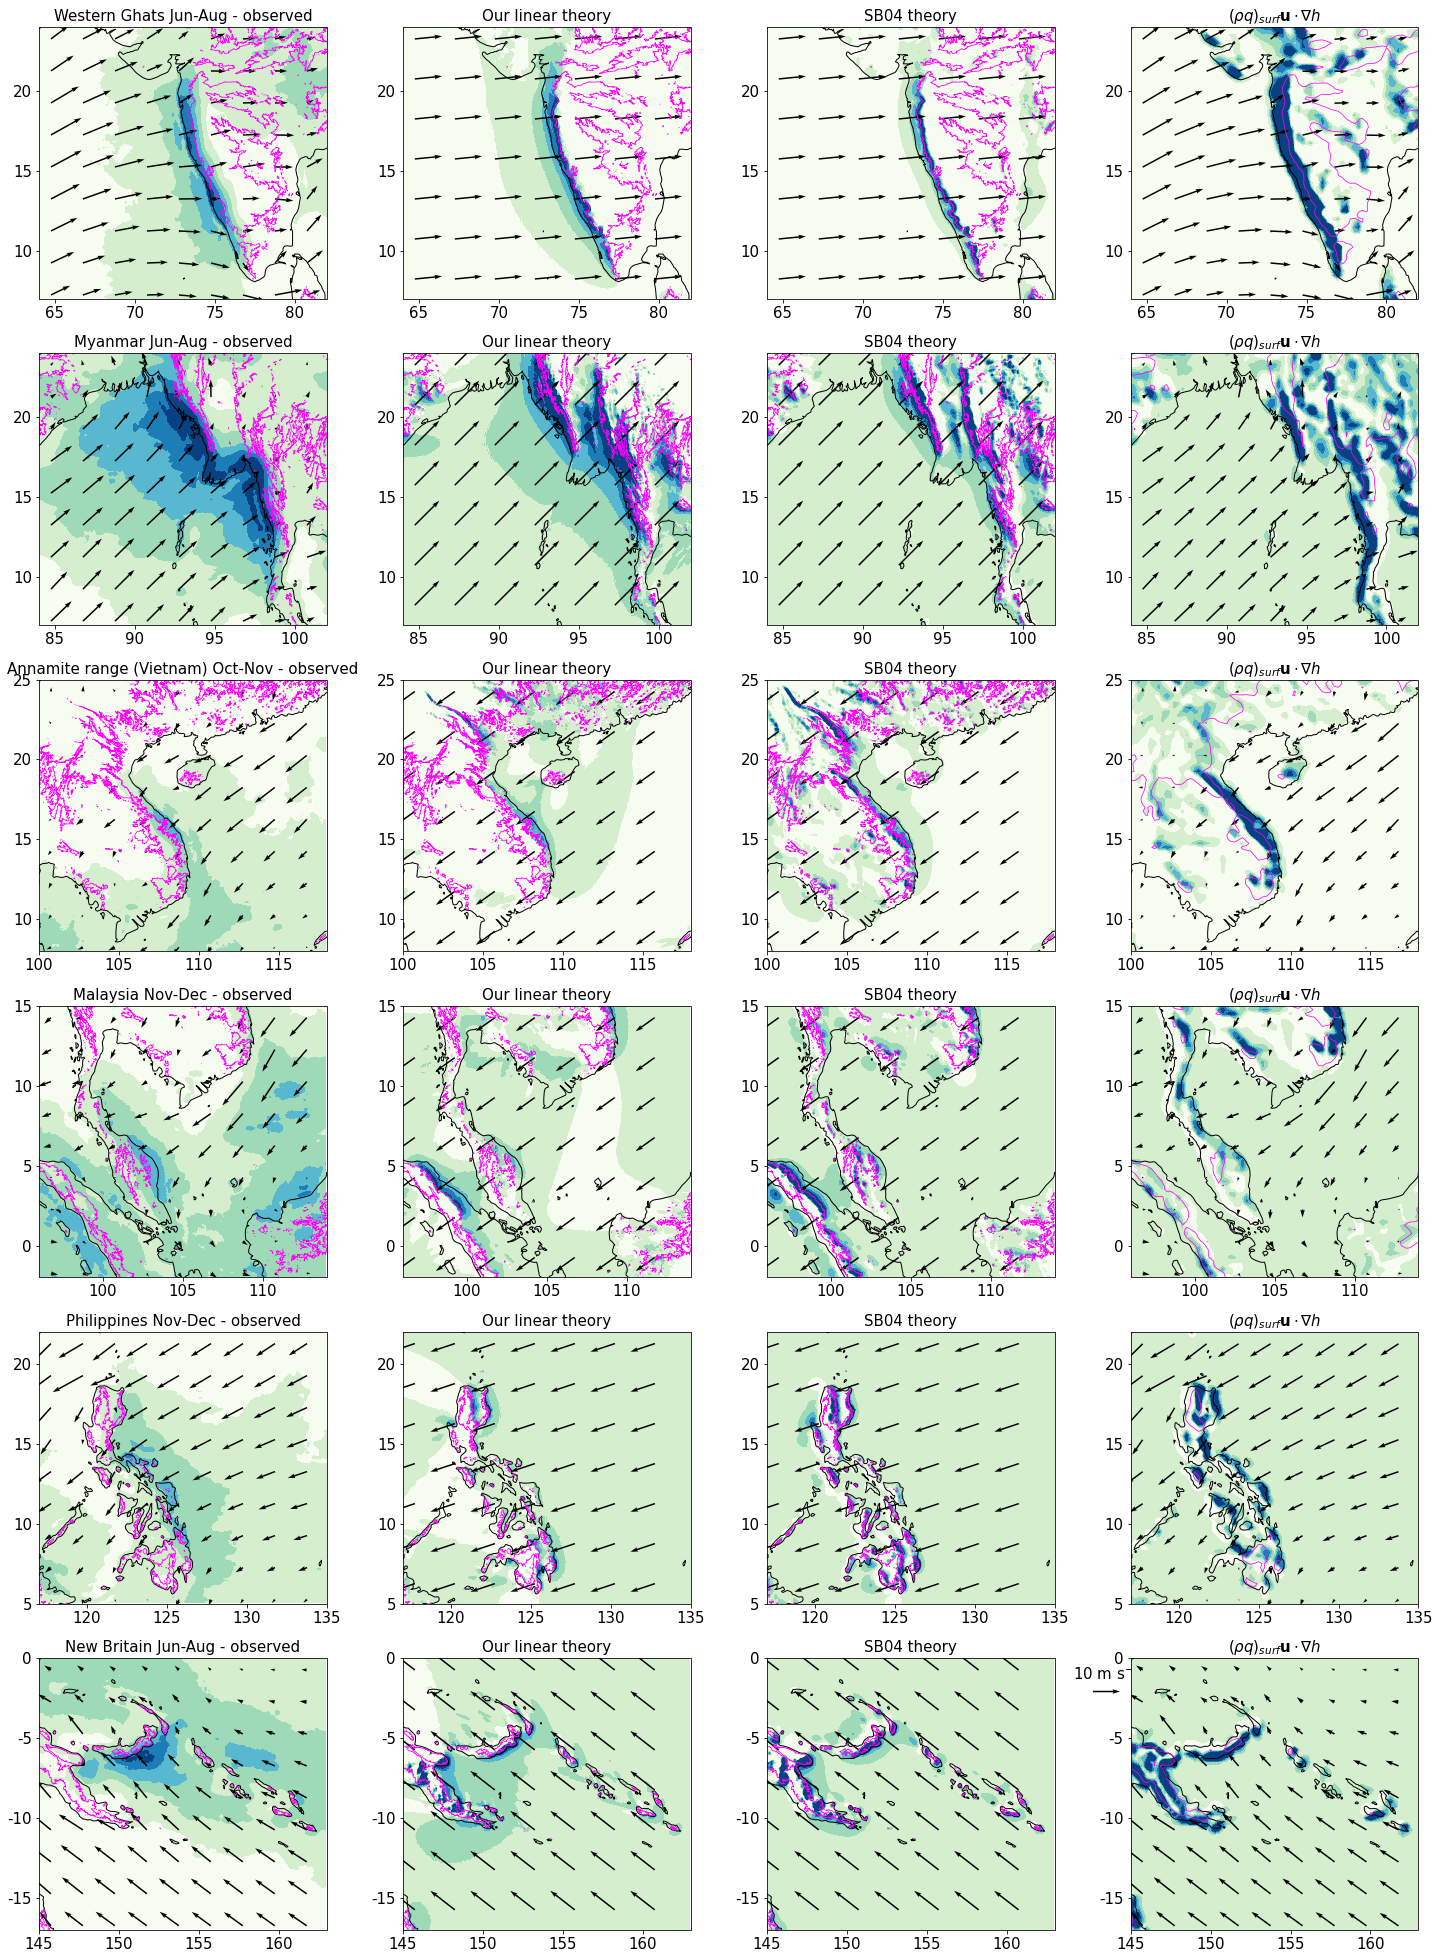

In [101]:
monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axss = plt.subplots(6,4,figsize=(25,35),subplot_kw={'projection': ccrs.PlateCarree()})
for i,MR in enumerate(MRs):
    axs = axss[i]
    
    ### FIRST COLUMN ###
    ax=axs[0]
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    ### SECOND COLUMN ###
    ax=axs[1]
    #p = p_lineartheory_region(MR,MR.U0,MR.V0,P0=MR.P0)
    p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
    p[0,0]=26.
    p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    ### THIRD COLUMN ###
    ax=axs[2]
    #p = p_smiththeory_region(MR,MR.U0,MR.V0,P0=MR.P0)
    p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
    p[0,0]=26.
    p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    ### FOURTH COLUMN ###
    ax=axs[3]
    m_per_degreelat = 6370*1e3*np.pi/180
    zsfc = MR.vars['Z']*sel_box(landmask,MR.box)
    p = 86400*1.2 * MR.vars['Q_SFC'] * (MR.vars['VAR_100U']*zsfc.differentiate('longitude')/m_per_degreelat
                                  +MR.vars['VAR_100V']*zsfc.differentiate('latitude')/m_per_degreelat)
    p = np.maximum(p+MR.P0,0.)
    p[0,0]=26.
    p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    ### QUIVERS ###
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    for ax in axs[0],axs[3]:
        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    n = int(n*1.25)
    m=n    
    for ax in axs[1:3]:

        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    for ax in axs[:3]:
        MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
    MR.vars['Z'].plot.contour(ax=axs[3],levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
    
    for ax in axs:
        ax.set_anchor('W')
        ax.coastlines()
        dl=5
        lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
        ax.set_xticks(lons)
        ax.set_xticklabels(lons)
        lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
        ax.set_yticks(lats)
        ax.set_yticklabels(lats)
        ax.set_xlabel("")
        ax.set_ylabel("")
    axs[0].set_title(MR.Lname +' '+monthnames[MR.months[0]-1]+'-'+monthnames[MR.months[-1]-1]+' - observed',fontsize=15)
    axs[1].set_title('Our linear theory',fontsize=15)
    axs[2].set_title('SB04 theory',fontsize=15)
    axs[3].set_title(r'$(\rho q)_{surf} \mathbf{u}\cdot\nabla h$',fontsize=15)

# Quiver key (reference wind arrow)
qk = axss[0,1].quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


## Cross-sections

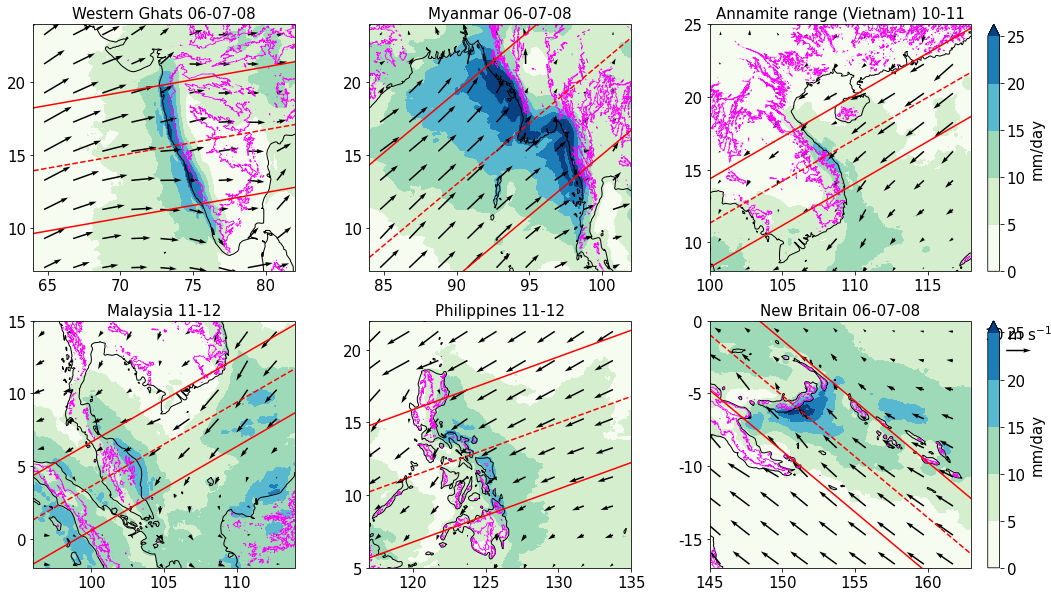

In [39]:
fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.2],height_ratios=[1,1],figure=fig)
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    ax.set_anchor('W')
    ax.coastlines()
    
    center=0.5; width=MR.width; clr='r'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    if i%3 !=2:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    else:
        pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,cbar_kwargs={'label':'mm/day'})
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
     
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+MR._monthstr,fontsize=15)
    

    

# Quiver key (reference wind arrow)
qk = ax.quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


In [17]:
Ghats      .angle = 80 ; Ghats      .width = 0.25
Myanmar    .angle = 50 ; Myanmar    .width = 0.25
Vietnam    .angle = 240; Vietnam    .width = 0.15
Malaysia   .angle = 240; Malaysia   .width = 0.15
Philippines.angle = 250; Philippines.width = 0.25
Newbritain .angle = 310; Newbritain .width = 0.15
Cascades   .angle =  50; Cascades   .width = 0.25

In [18]:
def rot_slice(var,angle,width):
    rvar = rotate_var(var.transpose('latitude','longitude'),angle)
    n,m = rvar.shape
    bounds = int(m*(0.5-width)), int(m*(0.5+width))
    return rvar.isel(y=slice(*bounds)).mean('y')

In [19]:
from scipy.ndimage import gaussian_filter

using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1
using dry stability, N=0.011 s^-1


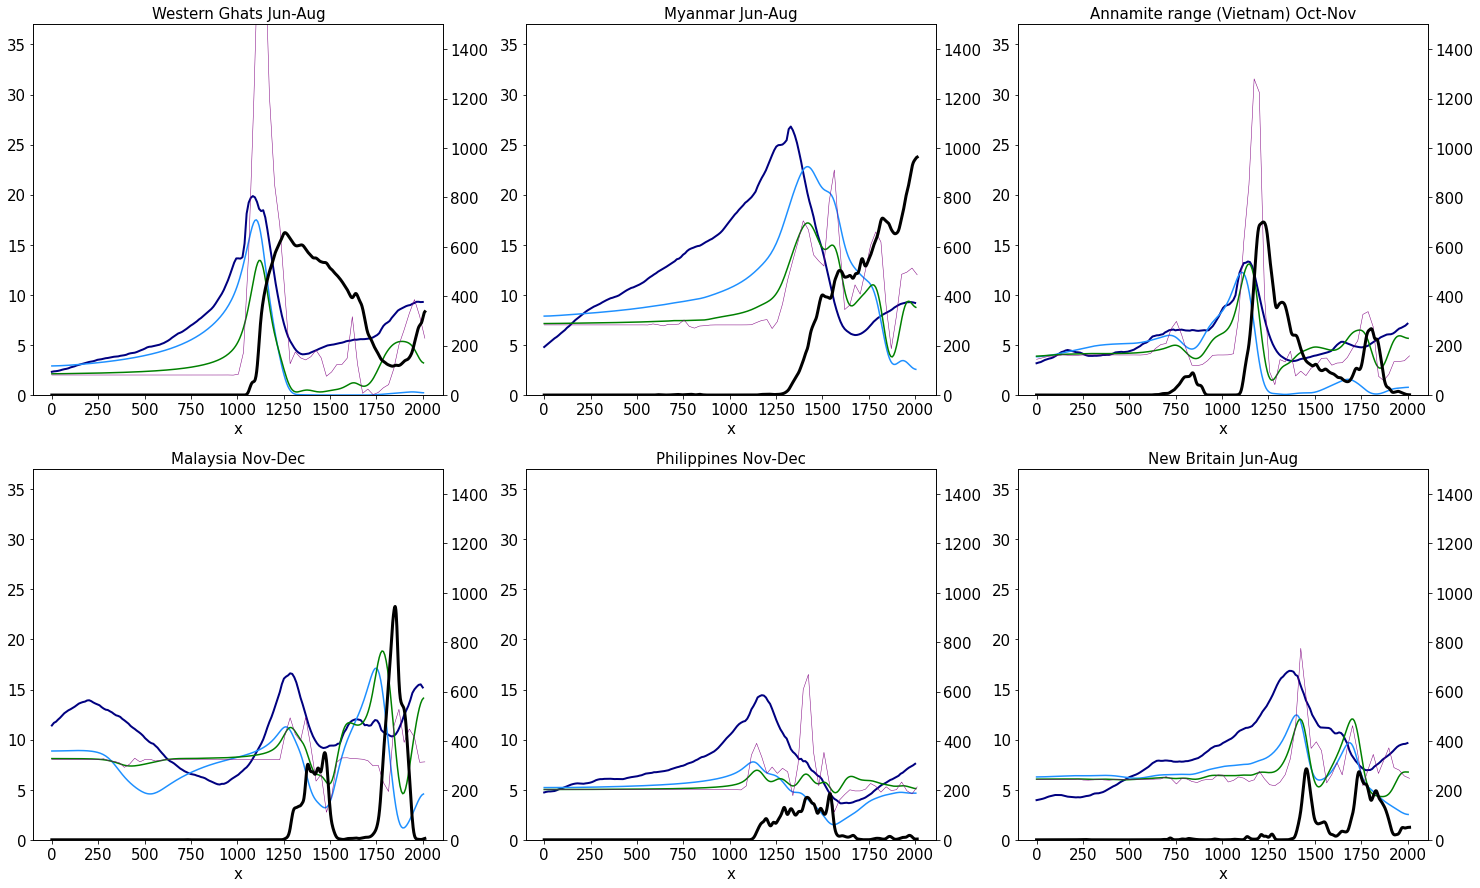

In [108]:
fig,axs = plt.subplots(2,3,figsize=(25,15))
axs=axs.reshape(-1)

for ax,MR in zip(axs,MRs):
    sigma=4
    ### FIRST ###
    pr=MR.vars['GPM_PR']
    rot_slice(pr,MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2)
    
    ### SECOND ###
    p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
    prot = rot_slice(p,MR.angle,MR.width)
    (prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='dodgerblue')
    
    ### THIRD ###
    p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
    prot = rot_slice(p,MR.angle,MR.width)
    (prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='g')

    ### FOURTH COLUMN ###
    m_per_degreelat = 6370*1e3*np.pi/180
    zsfc = MR.vars['Z']*sel_box(landmask,MR.box)
    p = 86400*1.2 * MR.vars['Q_SFC'] * (MR.vars['VAR_100U']*zsfc.differentiate('longitude')/m_per_degreelat
                                       +MR.vars['VAR_100V']*zsfc.differentiate('latitude')/m_per_degreelat)
    p = np.maximum(p+MR.P0,0.)
    rot_slice(p,MR.angle,MR.width).plot(ax=ax,color='purple',linewidth=0.5)
    
    ax2 = ax.twinx()
    hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
    (hrot**0*gaussian_filter(hrot,sigma)).plot(ax=ax2,color='k',linewidth=3)
        
    ax.set_ylim(0,37)
    ax2.set_ylim(0,1500)
    ax.set_title(MR.Lname +' '+monthnames[MR.months[0]-1]+'-'+monthnames[MR.months[-1]-1],fontsize=15)

using dry stability, N=0.011 s^-1


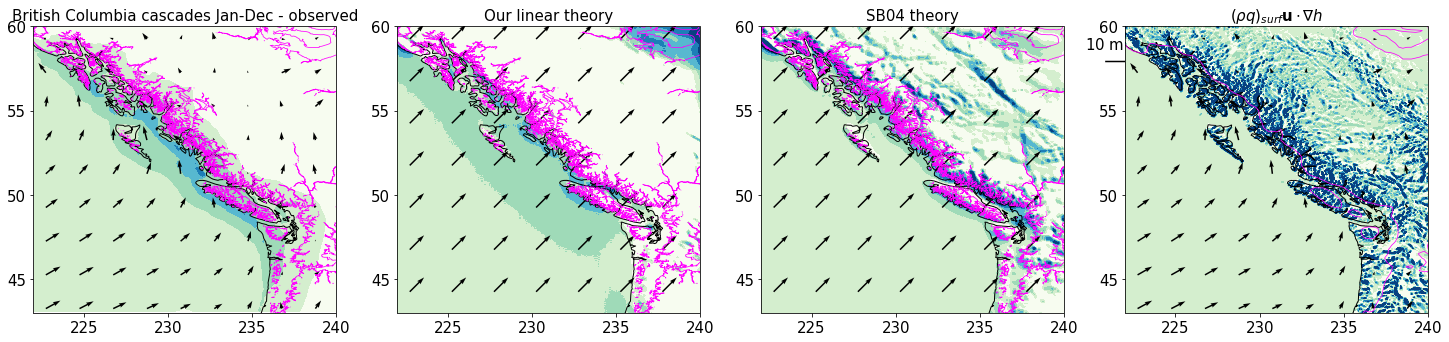

In [46]:
monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axs = plt.subplots(1,4,figsize=(25,7),subplot_kw={'projection': ccrs.PlateCarree()})
MR=Cascades
    
### FIRST COLUMN ###
ax=axs[0]
box=MR.box
pr=MR.vars['GPM_PR']
pr[0,0]=26.
pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### SECOND COLUMN ###
ax=axs[1]
#p = p_lineartheory_region(MR,MR.U0,MR.V0,P0=MR.P0)
p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### THIRD COLUMN ###
ax=axs[2]
#p = p_smiththeory_region(MR,MR.U0,MR.V0,P0=MR.P0)
p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### FOURTH COLUMN ###
ax=axs[3]
m_per_degreelat = 6370*1e3*np.pi/180
zsfc = MR.vars['Z_HR'].coarsen(latitude=3,longitude=3,boundary='trim').mean()#*sel_box(landmask,MR.box)
p = 86400*1.2 * MR.vars['Q_SFC'].interp_like(zsfc) * (MR.vars['VAR_100U'].interp_like(zsfc)*zsfc.differentiate('longitude')/m_per_degreelat*2
                                   +MR.vars['VAR_100V'].interp_like(zsfc)*zsfc.differentiate('latitude')/m_per_degreelat)
p = np.maximum(p+MR.P0,0.).fillna(0.)
p[0,0]=26.
p.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

### QUIVERS ###
u=MR.vars['VAR_100U']
v=MR.vars['VAR_100V']
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=len(u.latitude)//8
m=n
ibeg=3
iend=-1
for ax in axs[0],axs[3]:
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
n = int(n*1.25)
m=n    
for ax in axs[1:3]:
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
for ax in axs[:3]:
    MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())
MR.vars['Z'].plot.contour(ax=axs[3],levels=[500.],linewidths=[0.75],colors=['magenta'],transform=ccrs.PlateCarree())

for ax in axs:
    ax.set_anchor('W')
    ax.coastlines()
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks([l-360 for l in lons])
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title(MR.Lname +' '+monthnames[MR.months[0]-1]+'-'+monthnames[MR.months[-1]-1]+' - observed',fontsize=15)
axs[1].set_title('Our linear theory',fontsize=15)
axs[2].set_title('SB04 theory',fontsize=15)
axs[3].set_title(r'$(\rho q)_{surf} \mathbf{u}\cdot\nabla h$',fontsize=15)

# Quiver key (reference wind arrow)
qk = axs[1].quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')


using dry stability, N=0.011 s^-1


Text(0.5, 1.0, 'British Columbia cascades01-11-12')

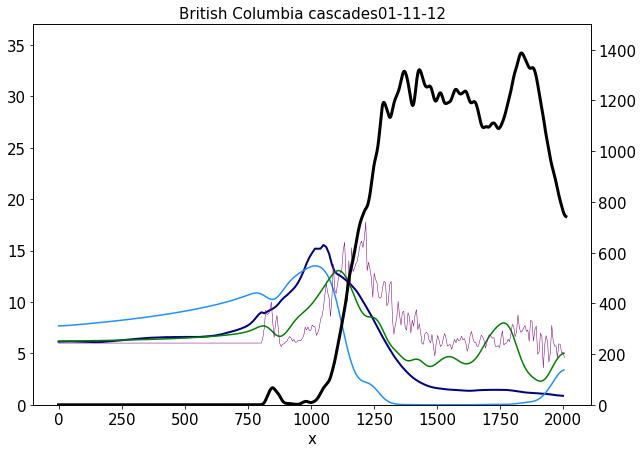

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
MR = Cascades
sigma=4
### FIRST ###
pr=MR.vars['GPM_PR']
rot_slice(pr,MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2)

### SECOND ###
p = p_lineartheory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
prot = rot_slice(p,MR.angle,MR.width)
(prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='dodgerblue')

### THIRD ###
p = p_smiththeory_region(MR,MR.U0,MR.V0,topo='ETOPOCOARSE',P0=MR.P0,pad='big')
prot = rot_slice(p,MR.angle,MR.width)
(prot**0*gaussian_filter(prot,sigma)).plot(ax=ax,color='g')

### FOURTH COLUMN ###
m_per_degreelat = 6370*1e3*np.pi/180
zsfc = MR.vars['Z_HR'].coarsen(latitude=3,longitude=3,boundary='trim').mean()#*sel_box(landmask,MR.box)
p = 86400*1.2 * MR.vars['Q_SFC'].interp_like(zsfc) * (MR.vars['VAR_100U'].interp_like(zsfc)*zsfc.differentiate('longitude')/m_per_degreelat*2
                                   +MR.vars['VAR_100V'].interp_like(zsfc)*zsfc.differentiate('latitude')/m_per_degreelat)
p = np.maximum(p+MR.P0,0.).fillna(0.)
rot_slice(p,MR.angle,MR.width).plot(ax=ax,color='purple',linewidth=0.5)


ax2 = ax.twinx()
hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
(hrot**0*gaussian_filter(hrot,sigma)).plot(ax=ax2,color='k',linewidth=3)
    
ax.set_ylim(0,37)
ax2.set_ylim(0,1500)
ax.set_title(MR.Lname + MR._monthstr,fontsize=15)